Imports

In [ ]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_fwf('/content/drive/MyDrive/Praca_licencjacka/zawody-2018-19.txt')
df.to_csv('zawody-2018-19.txt.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Praca_licencjacka/zawody-2018-19.txt', sep=';')
#df = pd.read_csv('/content/drive/MyDrive/Praca_licencjacka/zawody-2018-19.txt', sep=';', nrows=10000)

df.columns = ['Occupation_Code','Occupation_Name','Occupation_description']
df.head(5)

,Occupation_Code,Occupation_Name,Occupation_description
0,432103,magazynier paliw,całokształt prac zwiazanych z gospodarką magaz...
1,234201,Nauczyciel wychowania przedszkolnego,"Obowiązki opiekuńczo-wychowawczo-dydaktyczne, ..."
2,515303,PRACOWNIK PORZĄDKOWY (1/2 ETATU),"SPRZĄTANIE CHODNIKÓW, ODŚNIEŻANIE PRACA: 1 OSO..."
3,522301,Sprzedawca,Obsługa klientów klientów na hali sprzedaży or...
4,522301,Sprzedawca,"obsługa klienta, obsługa kasy fiskalnej"


In [ ]:
# getting basic info about the dataset
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709068 entries, 0 to 709067
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Occupation_Code         709068 non-null  int64 
 1   Occupation_Name         709068 non-null  object
 2   Occupation_description  709068 non-null  object
dtypes: int64(1), object(2)
memory usage: 16.2+ MB


(709068, 3)

In [ ]:
# checking for null values, if any
df.isnull().sum()

Occupation_Code           0
Occupation_Name           0
Occupation_description    0
dtype: int64

In [ ]:
#joining text columns together
df['Job_Name&Description'] = df['Occupation_Name'] + ' | ' + df['Occupation_description']
df.head(5)

,Occupation_Code,Occupation_Name,Occupation_description,Job_Name&Description
0,432103,magazynier paliw,całokształt prac zwiazanych z gospodarką magaz...,magazynier paliw | całokształt prac zwiazanych...
1,234201,Nauczyciel wychowania przedszkolnego,"Obowiązki opiekuńczo-wychowawczo-dydaktyczne, ...",Nauczyciel wychowania przedszkolnego | Obowiąz...
2,515303,PRACOWNIK PORZĄDKOWY (1/2 ETATU),"SPRZĄTANIE CHODNIKÓW, ODŚNIEŻANIE PRACA: 1 OSO...",PRACOWNIK PORZĄDKOWY (1/2 ETATU) | SPRZĄTANIE ...
3,522301,Sprzedawca,Obsługa klientów klientów na hali sprzedaży or...,Sprzedawca | Obsługa klientów klientów na hali...
4,522301,Sprzedawca,"obsługa klienta, obsługa kasy fiskalnej","Sprzedawca | obsługa klienta, obsługa kasy fis..."


In [ ]:
# initializing a new dataframe with only the Job_Name&Description column for faster operation
jobs_df = df[['Occupation_Code','Job_Name&Description']]

jobs_df.head(10)
#jobs_df.sample(10, random_state = 5)

,Occupation_Code,Job_Name&Description
0,432103,magazynier paliw | całokształt prac zwiazanych...
1,234201,Nauczyciel wychowania przedszkolnego | Obowiąz...
2,515303,PRACOWNIK PORZĄDKOWY (1/2 ETATU) | SPRZĄTANIE ...
3,522301,Sprzedawca | Obsługa klientów klientów na hali...
4,522301,"Sprzedawca | obsługa klienta, obsługa kasy fis..."
5,522301,Sprzedawca | obsługa klienta
6,522301,"Sprzedawca | Wprowadzanie faktur, dokumentów, ..."
7,712612,MONTER INSTALACJI | Wykonywanie wykopów pod ka...
8,522301,"Sprzedawca | Obsługa kasy fiskalnej, przyjmowa..."
9,932908,Pomocnik mechanika | .


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# Noise Cleaning - spacing, special characters, lowercasing
import regex as re
jobs_df['Job_Name&Description'] = jobs_df['Job_Name&Description'].str.lower()
jobs_df['Job_Name&Description'] = jobs_df['Job_Name&Description'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))

jobs_df.sample(10, random_state = 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Occupation_Code,Job_Name&Description
488066,817211,pracownik fizyczny w tartaku obróbka drewna p...
582690,833203,kierowca ce trasa krajowa cementonaczepa prz...
471607,311104,asystent geodety praktyczna pomoc w zakresie ...
332820,921490,pracownik porządkowy czynności związane utrz...
228167,242304,nauczyciel doradztwa zawodowego zajęcia z dor...
532322,515303,pracownik niewykwalifikowany pracownik niewyk...
221280,244002,rzeczoznawca praca na stanowisku rzeczoznawcy...
513171,814307,krajacz obsługa maszyn do krojenia papieru
11711,332302,zastępca kierownika działu zaopatrzenia ustal...
450678,512001,kucharz przygotowywanie posiłków dla dzieci w...


In [ ]:
#changing 'Occupation_Code' for string data stype
jobs_df.Occupation_Code = jobs_df.Occupation_Code.astype(str)
#jobs_df.sample(10)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
#formating 'Occupation_Code' for 6-digit numbers
jobs_df['Occupation_Code']=jobs_df['Occupation_Code'].str.pad(width=6, side='right', fillchar='0')
jobs_df.sample(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Occupation_Code,Job_Name&Description
366757,514190,pomoc fryzjera przyjmowanie klientówzapisyobs...
24091,815301,szwaczka maszynowa do uzgodnienia
667895,411090,pozostali pracownicy obsługi biurowej staż w...
499686,229201,fizjoterapeuta przeprowadzanie zabiegów z zak...
285027,325301,optyk okularowy optyk okularowy
72866,711401,betoniarz r87076920918 prace budowlane
88253,524902,doradca klienta praca biurowa rozliczanie dok...
265395,931301,pracownik ogólnobudowlany remonty klatek scho...
437344,441202,kurier wypełnianie listów przewozowych odbier...
659308,516490,pielęgniarz zwierząt obsługa zwierząt laborat...


In [ ]:
#nltk tokenization
jobs_df['tokenized_Job_Name&Description'] = jobs_df['Job_Name&Description'].apply(word_tokenize)
jobs_df.sample(10, random_state = 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Occupation_Code,Job_Name&Description,tokenized_Job_Name&Description
488066,817211,pracownik fizyczny w tartaku obróbka drewna p...,"[pracownik, fizyczny, w, tartaku, obróbka, dre..."
582690,833203,kierowca ce trasa krajowa cementonaczepa prz...,"[kierowca, ce, trasa, krajowa, cementonaczepa,..."
471607,311104,asystent geodety praktyczna pomoc w zakresie ...,"[asystent, geodety, praktyczna, pomoc, w, zakr..."
332820,921490,pracownik porządkowy czynności związane utrz...,"[pracownik, porządkowy, czynności, związane, u..."
228167,242304,nauczyciel doradztwa zawodowego zajęcia z dor...,"[nauczyciel, doradztwa, zawodowego, zajęcia, z..."
532322,515303,pracownik niewykwalifikowany pracownik niewyk...,"[pracownik, niewykwalifikowany, pracownik, nie..."
221280,244002,rzeczoznawca praca na stanowisku rzeczoznawcy...,"[rzeczoznawca, praca, na, stanowisku, rzeczozn..."
513171,814307,krajacz obsługa maszyn do krojenia papieru,"[krajacz, obsługa, maszyn, do, krojenia, papieru]"
11711,332302,zastępca kierownika działu zaopatrzenia ustal...,"[zastępca, kierownika, działu, zaopatrzenia, u..."
450678,512001,kucharz przygotowywanie posiłków dla dzieci w...,"[kucharz, przygotowywanie, posiłków, dla, dzie..."


Stopwords

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords.fileids()

['arabic',
 'azerbaijani',
 'bengali',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'greek',
 'hungarian',
 'indonesian',
 'italian',
 'kazakh',
 'nepali',
 'norwegian',
 'portuguese',
 'romanian',
 'russian',
 'slovene',
 'spanish',
 'swedish',
 'tajik',
 'turkish']

Stopwords

In [ ]:
stop_words = pd.read_fwf('/content/drive/MyDrive/Praca_licencjacka/stopwords_pl.txt')
stop_words

,a
0,aby
1,ach
2,acz
3,aczkolwiek
4,aj
...,...
344,żadna
345,żadne
346,żadnych
347,że


In [ ]:
#removing stopwords

jobs_df['tokenized_Job_Name&Description'] = jobs_df['tokenized_Job_Name&Description'].apply(lambda x: [word for word in x if word not in stop_words])
jobs_df['tokenized_Job_Name&Description_join'] = [' '.join(map(str, l)) for l in jobs_df['tokenized_Job_Name&Description']]

jobs_df.sample(10, random_state = 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Occupation_Code,Job_Name&Description,tokenized_Job_Name&Description,tokenized_Job_Name&Description_join
488066,817211,pracownik fizyczny w tartaku obróbka drewna p...,"[pracownik, fizyczny, w, tartaku, obróbka, dre...",pracownik fizyczny w tartaku obróbka drewna pr...
582690,833203,kierowca ce trasa krajowa cementonaczepa prz...,"[kierowca, ce, trasa, krajowa, cementonaczepa,...",kierowca ce trasa krajowa cementonaczepa przew...
471607,311104,asystent geodety praktyczna pomoc w zakresie ...,"[asystent, geodety, praktyczna, pomoc, w, zakr...",asystent geodety praktyczna pomoc w zakresie p...
332820,921490,pracownik porządkowy czynności związane utrz...,"[pracownik, porządkowy, czynności, związane, u...",pracownik porządkowy czynności związane utrzym...
228167,242304,nauczyciel doradztwa zawodowego zajęcia z dor...,"[nauczyciel, doradztwa, zawodowego, zajęcia, z...",nauczyciel doradztwa zawodowego zajęcia z dora...
532322,515303,pracownik niewykwalifikowany pracownik niewyk...,"[pracownik, niewykwalifikowany, pracownik, nie...",pracownik niewykwalifikowany pracownik niewykw...
221280,244002,rzeczoznawca praca na stanowisku rzeczoznawcy...,"[rzeczoznawca, praca, na, stanowisku, rzeczozn...",rzeczoznawca praca na stanowisku rzeczoznawcy ...
513171,814307,krajacz obsługa maszyn do krojenia papieru,"[krajacz, obsługa, maszyn, do, krojenia, papieru]",krajacz obsługa maszyn do krojenia papieru
11711,332302,zastępca kierownika działu zaopatrzenia ustal...,"[zastępca, kierownika, działu, zaopatrzenia, u...",zastępca kierownika działu zaopatrzenia ustala...
450678,512001,kucharz przygotowywanie posiłków dla dzieci w...,"[kucharz, przygotowywanie, posiłków, dla, dzie...",kucharz przygotowywanie posiłków dla dzieci w ...


In [ ]:
#Clean data
clean_df = jobs_df [['Occupation_Code','tokenized_Job_Name&Description_join']]
clean_df.head(10)

,Occupation_Code,tokenized_Job_Name&Description_join
0,432103,magazynier paliw całokształt prac zwiazanych z...
1,234201,nauczyciel wychowania przedszkolnego obowiązki...
2,515303,pracownik porządkowy 12 etatu sprzątanie chodn...
3,522301,sprzedawca obsługa klientów klientów na hali s...
4,522301,sprzedawca obsługa klienta obsługa kasy fiskalnej
5,522301,sprzedawca obsługa klienta
6,522301,sprzedawca wprowadzanie faktur dokumentów sprz...
7,712612,monter instalacji wykonywanie wykopów pod kana...
8,522301,sprzedawca obsługa kasy fiskalnej przyjmowanie...
9,932908,pomocnik mechanika


In [ ]:
clean_df.isnull().sum()

Occupation_Code                        0
tokenized_Job_Name&Description_join    0
dtype: int64

In [ ]:
#przypisanie do kat
clean_df['KZiS_category'] = clean_df['Occupation_Code'].astype(str).str[0]
clean_df.sample(10, random_state = 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Occupation_Code,tokenized_Job_Name&Description_join,KZiS_category
488066,817211,pracownik fizyczny w tartaku obróbka drewna pr...,8
582690,833203,kierowca ce trasa krajowa cementonaczepa przew...,8
471607,311104,asystent geodety praktyczna pomoc w zakresie p...,3
332820,921490,pracownik porządkowy czynności związane utrzym...,9
228167,242304,nauczyciel doradztwa zawodowego zajęcia z dora...,2
532322,515303,pracownik niewykwalifikowany pracownik niewykw...,5
221280,244002,rzeczoznawca praca na stanowisku rzeczoznawcy ...,2
513171,814307,krajacz obsługa maszyn do krojenia papieru,8
11711,332302,zastępca kierownika działu zaopatrzenia ustala...,3
450678,512001,kucharz przygotowywanie posiłków dla dzieci w ...,5


In [ ]:
#Ile jest rekordów w każdej kategorii
df_count = clean_df['KZiS_category'].value_counts()
df_count

5    138888
7    134159
9    124251
4     77780
8     76059
2     75635
3     65891
1     11224
6      5179
0         2
Name: KZiS_category, dtype: int64

In [ ]:
#usuwamy wszystkie wiersze, dla których occupation code nie zaczyna się od 6 lub 10 i 0
df=clean_df.loc[~df['Occupation_Code'].astype(str).str.startswith(('0','6', '10'))]
df.head(5)

,Occupation_Code,tokenized_Job_Name&Description_join,KZiS_category
0,432103,magazynier paliw całokształt prac zwiazanych z...,4
1,234201,nauczyciel wychowania przedszkolnego obowiązki...,2
2,515303,pracownik porządkowy 12 etatu sprzątanie chodn...,5
3,522301,sprzedawca obsługa klientów klientów na hali s...,5
4,522301,sprzedawca obsługa klienta obsługa kasy fiskalnej,5


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

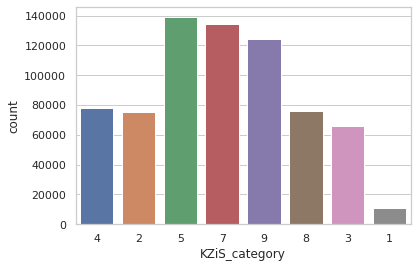

In [ ]:
sns.countplot(x="KZiS_category",data=df)

In [ ]:
df.drop('Occupation_Code', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df.rename(columns={'tokenized_Job_Name&Description_join':'text', 'KZiS_category':'cat'}, inplace=True)
df.head(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,text,cat
0,magazynier paliw całokształt prac zwiazanych z...,4
1,nauczyciel wychowania przedszkolnego obowiązki...,2
2,pracownik porządkowy 12 etatu sprzątanie chodn...,5
3,sprzedawca obsługa klientów klientów na hali s...,5
4,sprzedawca obsługa klienta obsługa kasy fiskalnej,5


In [ ]:
#ile słów w kolumnie text
print(df['text'].apply(lambda x: len(x.split(' '))).sum())


14212787


In [ ]:
#sprawdzenie kategorii (data exploration)
def print_plot(index):
    example = df[df.index == index][['text', 'cat']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])
print_plot(10)

operator maszyn prawidłowe wykonywanie zadań produkcyjnych na wyznaczonym odcinku odpowiadanie za utrzymanie w ruchu maszyn i urządzeń uruchamianie maszyny za pomocą pulpitów sterujących zgodnie z obowiązującymi instrukcjami obsługi maszyn bezpośredni nadzor nad pracą maszyn wykonywanie nałożonych i wytyczonych zadań przez kierownika zmiany dbanie o powierzoną maszynę pilnowanie ciągłości wykonywanej pracy współpraca z ustawiaczami maszyn oraz innymi operatorami urządzeń współpracujących w celu zachowania ciągłości wykonywanej produkcji
Tag: 8


In [ ]:
print_plot(30)


nauczyciel przedszkola prowadzenie zajęć dydaktycznowychowawczych z dziećmi
Tag: 2


After splitting the data set, the next steps includes feature engineering. I will convert the text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). After that, we can train several classifiers from Scikit-Learn library

In [ ]:
X = df.text
y = df.cat
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [ ]:
#to know the shape of the train and test dataset.
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(492720,)
(492720,)
(211167,)
(211167,)


## Naive Bayes Classifier for Multinomial Models


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
accuracy 0.7899529756069841
              precision    recall  f1-score   support

           1       0.91      0.04      0.08      3440
           2       0.76      0.81      0.79     22833
           3       0.75      0.54      0.63     19783
           4       0.77      0.80      0.78     23197
           5       0.82      0.87      0.85     41669
           7       0.77      0.92      0.84     40285
           8       0.88      0.70      0.78     22675
           9       0.78      0.80      0.79     37285

    accuracy                           0.79    211167
   macro avg       0.81      0.68      0.69    211167
weighted avg       0.79      0.79      0.78    211167



In [ ]:
np.unique(y_test), np.unique(y_pred)

(array(['1', '2', '3', '4', '5', '7', '8', '9'], dtype=object),
 array(['1', '2', '3', '4', '5', '7', '8', '9'], dtype='<U1'))

In [ ]:
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(8,4)) --> figsize = wielkość tabeli x,y
# sns.heatmap(cm, annot=True)
# plt.title('Confusion Matrix')
# plt.ylabel('Actal Values')
# plt.xlabel('Predicted Values')
# plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
cm2=confusion_matrix(y_test, y_pred)
cm2

array([[  139,  1480,   750,   189,   566,   189,    12,   115],
       [    2, 18525,  1116,  1433,  1129,   525,    13,    90],
       [    3,  2030, 10735,  2422,  1891,  1823,   361,   518],
       [    1,  1119,   670, 18458,  1308,   147,   493,  1001],
       [    3,   859,   593,   484, 36277,   309,    93,  3051],
       [    1,   130,   172,    44,   399, 36969,   529,  2041],
       [    0,    33,   122,   342,   256,  4447, 15818,  1657],
       [    3,    52,    81,   619,  2169,  3843,   627, 29891]])

Confusion matrix --> contains the number of observations classified into particular classes.

Text(0.5, 12.5, 'Predicted Values')

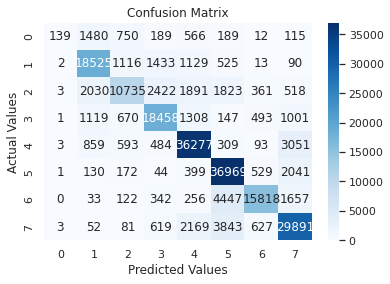

In [ ]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')


Walidacja Krzyżowa --> Cross Validation

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=8, random_state=9, shuffle=True)
kfold

KFold(n_splits=8, random_state=9, shuffle=True)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=nb, X=X_test, y=y_pred, cv=kfold)

In [ ]:
scores

array([0.88358085, 0.88577815, 0.88441431, 0.88180027, 0.89070314,
       0.88456584, 0.88327777, 0.88221254])

In [ ]:
print(f'Średnia dokładność: {scores.mean():.2%}')
print(f'Odchylenie standardowe dokładności: {scores.std():.2%}')

Średnia dokładność: 88.45%
Odchylenie standardowe dokładności: 0.26%


%Confusion matrix --> contains the percentage of observations classified to particular classes expressed as a percentage (number / number of all observations).

Text(0.5, 12.5, 'Predicted Values')

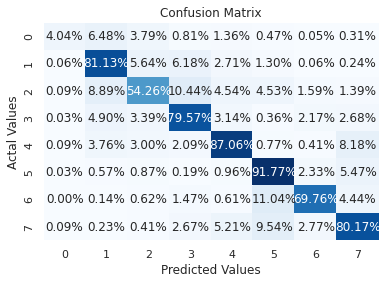

In [ ]:
cm_proc = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()
sns.heatmap(cm_proc/np.sum(cm_proc, axis=1 ), annot=True, fmt='.2%', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

#fig, ax = plt.subplots(nrows=1, ncols=2)

In [ ]:
cm_proc

array([[  139,  1480,   750,   189,   566,   189,    12,   115],
       [    2, 18525,  1116,  1433,  1129,   525,    13,    90],
       [    3,  2030, 10735,  2422,  1891,  1823,   361,   518],
       [    1,  1119,   670, 18458,  1308,   147,   493,  1001],
       [    3,   859,   593,   484, 36277,   309,    93,  3051],
       [    1,   130,   172,    44,   399, 36969,   529,  2041],
       [    0,    33,   122,   342,   256,  4447, 15818,  1657],
       [    3,    52,    81,   619,  2169,  3843,   627, 29891]])

In [ ]:
np.unique(y_pred)
np.unique(y_test)

array(['1', '2', '3', '4', '5', '7', '8', '9'], dtype=object)

## Linear Support Vector Machine
Linear Support Vector Machine is widely regarded as one of the best text classification algorithms.

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

%time

y_pred_svm = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred_svm, y_test))
print(classification_report(y_test, y_pred_svm))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
accuracy 0.7945038760791222
              precision    recall  f1-score   support

           1       0.78      0.52      0.62      3440
           2       0.79      0.80      0.79     22833
           3       0.84      0.45      0.59     19783
           4       0.77      0.82      0.79     23197
           5       0.83      0.89      0.86     41669
           7       0.76      0.88      0.81     40285
           8       0.82      0.75      0.78     22675
           9       0.79      0.81      0.80     37285

    accuracy                           0.79    211167
   macro avg       0.80      0.74      0.76    211167
weighted avg       0.80      0.79      0.79    211167



In [ ]:
from sklearn.model_selection import cross_val_score
scores_svm = cross_val_score(estimator=sgd, X=X_test, y=y_pred_svm, cv=kfold)

In [ ]:
scores_svm

array([0.9292317 , 0.93074708, 0.92608729, 0.92915593, 0.92790574,
       0.93010305, 0.92847401, 0.93135063])

In [ ]:
print(f'Średnia dokładność: {scores_svm.mean():.2%}')
print(f'Odchylenie standardowe dokładności: {scores_svm.std():.2%}')

Średnia dokładność: 92.91%
Odchylenie standardowe dokładności: 0.16%


Text(0.5, 12.5, 'Predicted Values')

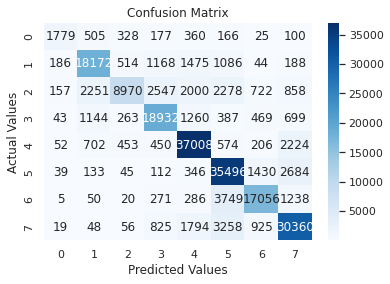

In [ ]:
cm_svm = confusion_matrix(y_test, y_pred_svm)

fig, ax = plt.subplots()
sns.heatmap(cm_svm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

Text(0.5, 12.5, 'Predicted Values')

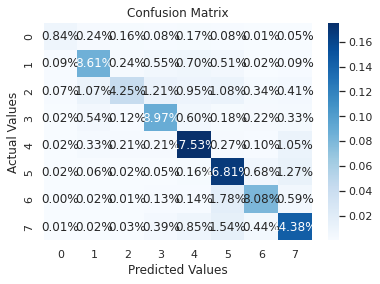

In [ ]:
cm_svm_proc = confusion_matrix(y_test, y_pred_svm)

fig, ax = plt.subplots()
sns.heatmap(cm_svm_proc/np.sum(cm_svm_proc), annot=True, fmt='.2%', ax=ax, cmap=plt.cm.Blues,
            cbar=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

## Logistic Regression
Logistic regression can be easily generalized to multiple classes.

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

%time

y_pred_logreg = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred_logreg, y_test))
print(classification_report(y_test, y_pred_logreg))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
accuracy 0.8601722807067392
              precision    recall  f1-score   support

           1       0.77      0.77      0.77      3440
           2       0.85      0.85      0.85     22833
           3       0.78      0.72      0.75     19783
           4       0.85      0.86      0.85     23197
           5       0.91      0.91      0.91     41669
           7       0.88      0.89      0.88     40285
           8       0.85      0.85      0.85     22675
           9       0.85      0.86      0.86     37285

    accuracy                           0.86    211167
   macro avg       0.84      0.84      0.84    211167
weighted avg       0.86      0.86      0.86    211167



Text(0.5, 12.5, 'Predicted Values')

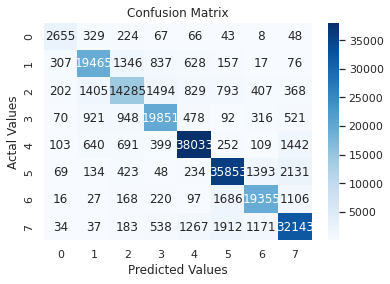

In [ ]:
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

fig, ax = plt.subplots()
sns.heatmap(cm_logreg, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

Text(0.5, 12.5, 'Predicted Values')

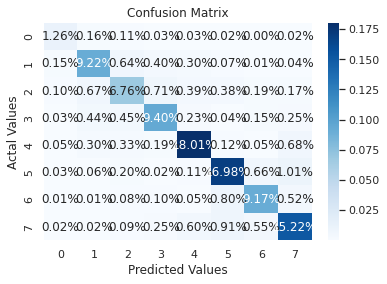

In [ ]:
cm_logreg_proc = confusion_matrix(y_test, y_pred_logreg)

fig, ax = plt.subplots()
sns.heatmap(cm_logreg_proc/np.sum(cm_logreg_proc), annot=True, fmt='.2%', ax=ax, cmap=plt.cm.Blues,
            cbar=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

In [ ]:
from sklearn.model_selection import cross_val_score
scores_logreg = cross_val_score(estimator=logreg, X=X_test, y=y_pred_logreg, cv=kfold)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
scores_logreg

array([0.95722837, 0.95586452, 0.95988028, 0.95844067, 0.95938779,
       0.95654645, 0.95703895, 0.95662057])

In [ ]:
print(f'Średnia dokładność: {scores_logreg.mean():.2%}')
print(f'Odchylenie standardowe dokładności: {scores_logreg.std():.2%}')

Średnia dokładność: 95.76%
Odchylenie standardowe dokładności: 0.14%


In [ ]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
estimators = {
    # 'SVC': SVC(gamma='scale'),
    # 'GaussianNB': GaussianNB(),
    'LogisticRegression': logreg,
    'SGDClassifier': sgd,
    'MultinomialNB': nb
}

In [ ]:
for estimator_name, estimator_object in estimators.items():
  kfold = KFold(n_splits=3, random_state=11, shuffle=True)
  scores = cross_val_score(estimator=estimator_object, X=X_test, y=y_pred, cv=kfold)
  print(f'{estimator_name:>20}: '+
        f'Średnia dokładność={scores.mean():.2%}; ' +
        f'Odchylenie standardowe dokładności= {scores.std():.2%}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


  LogisticRegression: Średnia dokładność=93.34%; Odchylenie standardowe dokładności= 0.10%
       SGDClassifier: Średnia dokładność=84.48%; Odchylenie standardowe dokładności= 0.06%
       MultinomialNB: Średnia dokładność=87.96%; Odchylenie standardowe dokładności= 0.09%


#Nowe dane


In [ ]:
new_data = pd.read_csv('/content/drive/MyDrive/Praca_licencjacka/new_data.csv')
new_data

,id_unit,id_oferty,id_os,class,desc
0,44,3300,1,411090,pracownik obsługi biurowej Staż z urzędu pracy...
1,208,3232,2,332203,"handlowiec pracownik biurowy Oferta pracy , pr..."
2,368,3330,3,411090,"pomoc biurowa Oferta pracy , Umowa zlecenie /..."
3,368,3330,3,411004,"pomoc biurowa Oferta pracy , Umowa zlecenie /..."
4,505,3273,2,911290,sprzątaczka biurowa INWEMER SYSTEM SPÓŁKA Z...
...,...,...,...,...,...
10077,1390361,1944,1,911207,sprzątaczka - praca dodatkowa pełny etat umowa...
10078,1390530,680,2,912990,"sprzątaczka, pracownik gospodarczy - warszawa ..."
10079,1390655,402,3,912990,"sprzątaczka, pracownik gospodarczy Stała Umowa..."
10080,1390781,51,3,912990,praca sprzątanie sprzątaczka Stała Umowa zlece...


In [ ]:
# getting basic info about the dataset
new_data.info()
new_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10082 entries, 0 to 10081
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_unit    10082 non-null  int64 
 1   id_oferty  10082 non-null  int64 
 2   id_os      10082 non-null  int64 
 3   class      10082 non-null  int64 
 4   desc       10082 non-null  object
dtypes: int64(4), object(1)
memory usage: 394.0+ KB


(10082, 5)

In [ ]:
# checking for null values, if any
df.isnull().sum()

text    0
cat     0
dtype: int64

In [ ]:
#Droping unnecessary columns
new_data = new_data[['class','desc']]

In [ ]:
# Noise Cleaning - spacing, special characters, lowercasing
new_data['desc'] = new_data['desc'].str.lower()
new_data['desc'] = new_data['desc'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))
new_data.sample(10, random_state = 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,class,desc
4420,242204,inspektor projektant audytor w dziale inspekc...
2111,741103,elektrykautomatyk do wyposażania przemysłowych...
3211,142004,kierownik sklepu pełny etat umowa o pracę kier...
6745,132301,kierownik projektu budownictwo infrastruktura...
4623,242390,koordynator zmiany contact center pełny etat u...
3803,721204,spawaczmonter nr 4469 centralna baza ofert ...
6939,524990,koordynator stoiska pełny etat umowa o pracę k...
1987,722308,operator maszyn cnc stała szczegóły ogłoszeni...
3688,232004,nauczyciel technik masażysta centrum nauki ...
7876,311211,starszy inspektor ds kontroli główny urząd ...


In [ ]:
#changing 'class' for string data stype
new_data['class'] = new_data['class'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#formating 'class' for 6-digit numbers
new_data['class']=new_data['class'].str.pad(width=6, side='right', fillchar='0')
new_data.sample(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,class,desc
9221,522301,specjalista mkiosk pełny etat umowa zlecenie ...
6013,235919,przedszkole poszukiwany nauczyciel wspomagając...
8883,332203,przedstawiciel handlowy pełny etat umowa o pra...
9927,251202,główny specjalista ds systemów informatycznych...
497,522301,sprzedawca netto sp z oo kto szuka netto s...
9782,242108,starszy specjalista ds oceny dostawców w biurz...
9998,213105,specjalista badawczotechniczny pełny etat umow...
1000,311514,płatny staż w dziale utrzymania ruchu sylva...
1021,221236,lekarz internista medycyny rodzinnej część et...
7882,242211,ekspert komenda stołeczna policji zakres o...


In [ ]:
#nltk tokenization
new_data['desc_tokenized'] = new_data['desc'].apply(word_tokenize)
new_data.sample(10, random_state = 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,class,desc,desc_tokenized
4420,242204,inspektor projektant audytor w dziale inspekc...,"[inspektor, projektant, audytor, w, dziale, in..."
2111,741103,elektrykautomatyk do wyposażania przemysłowych...,"[elektrykautomatyk, do, wyposażania, przemysło..."
3211,142004,kierownik sklepu pełny etat umowa o pracę kier...,"[kierownik, sklepu, pełny, etat, umowa, o, pra..."
6745,132301,kierownik projektu budownictwo infrastruktura...,"[kierownik, projektu, budownictwo, infrastrukt..."
4623,242390,koordynator zmiany contact center pełny etat u...,"[koordynator, zmiany, contact, center, pełny, ..."
3803,721204,spawaczmonter nr 4469 centralna baza ofert ...,"[spawaczmonter, nr, 4469, centralna, baza, ofe..."
6939,524990,koordynator stoiska pełny etat umowa o pracę k...,"[koordynator, stoiska, pełny, etat, umowa, o, ..."
1987,722308,operator maszyn cnc stała szczegóły ogłoszeni...,"[operator, maszyn, cnc, stała, szczegóły, ogło..."
3688,232004,nauczyciel technik masażysta centrum nauki ...,"[nauczyciel, technik, masażysta, centrum, nauk..."
7876,311211,starszy inspektor ds kontroli główny urząd ...,"[starszy, inspektor, ds, kontroli, główny, urz..."


In [ ]:
#removing stopwords

new_data['desc_tokenized'] = new_data['desc_tokenized'].apply(lambda x: [word for word in x if word not in stop_words])
new_data['desc_tokenized&joined'] = [' '.join(map(str, l)) for l in new_data['desc_tokenized']]

new_data.sample(10, random_state = 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,class,desc,desc_tokenized,desc_tokenized&joined
4420,242204,inspektor projektant audytor w dziale inspekc...,"[inspektor, projektant, audytor, w, dziale, in...",inspektor projektant audytor w dziale inspekcj...
2111,741103,elektrykautomatyk do wyposażania przemysłowych...,"[elektrykautomatyk, do, wyposażania, przemysło...",elektrykautomatyk do wyposażania przemysłowych...
3211,142004,kierownik sklepu pełny etat umowa o pracę kier...,"[kierownik, sklepu, pełny, etat, umowa, o, pra...",kierownik sklepu pełny etat umowa o pracę kier...
6745,132301,kierownik projektu budownictwo infrastruktura...,"[kierownik, projektu, budownictwo, infrastrukt...",kierownik projektu budownictwo infrastruktural...
4623,242390,koordynator zmiany contact center pełny etat u...,"[koordynator, zmiany, contact, center, pełny, ...",koordynator zmiany contact center pełny etat u...
3803,721204,spawaczmonter nr 4469 centralna baza ofert ...,"[spawaczmonter, nr, 4469, centralna, baza, ofe...",spawaczmonter nr 4469 centralna baza ofert pra...
6939,524990,koordynator stoiska pełny etat umowa o pracę k...,"[koordynator, stoiska, pełny, etat, umowa, o, ...",koordynator stoiska pełny etat umowa o pracę k...
1987,722308,operator maszyn cnc stała szczegóły ogłoszeni...,"[operator, maszyn, cnc, stała, szczegóły, ogło...",operator maszyn cnc stała szczegóły ogłoszenia...
3688,232004,nauczyciel technik masażysta centrum nauki ...,"[nauczyciel, technik, masażysta, centrum, nauk...",nauczyciel technik masażysta centrum nauki i b...
7876,311211,starszy inspektor ds kontroli główny urząd ...,"[starszy, inspektor, ds, kontroli, główny, urz...",starszy inspektor ds kontroli główny urząd nad...


In [ ]:
#Clean data
data = new_data[['class','desc_tokenized&joined']]
data.head(10)

,class,desc_tokenized&joined
0,411090,pracownik obsługi biurowej staż z urzędu pracy...
1,332203,handlowiec pracownik biurowy oferta pracy prac...
2,411090,pomoc biurowa oferta pracy umowa zlecenie umow...
3,411004,pomoc biurowa oferta pracy umowa zlecenie umow...
4,911290,sprzątaczka biurowa inwemer system spółka z og...
5,411090,pozostali pracownicy obsługi biurowej pełny et...
6,911290,sprzątaczka biurowapracownik do pracy lekkiej ...
7,911207,sprzątaczka biurowa staż pełny etat stażprakty...
8,411003,pozostali pracownicy obsługi biurowej pracowni...
9,411004,pracownik obsługi biurowej oferta pracy umowa ...


In [ ]:
#usuwamy wszystkie wiersze, dla których occupation code nie zaczyna się od 6 lub 10 i 0
data=data.loc[~data['class'].astype(str).str.startswith(('0','6', '10'))]
data.head(5)

,class,desc_tokenized&joined
0,411090,pracownik obsługi biurowej staż z urzędu pracy...
1,332203,handlowiec pracownik biurowy oferta pracy prac...
2,411090,pomoc biurowa oferta pracy umowa zlecenie umow...
3,411004,pomoc biurowa oferta pracy umowa zlecenie umow...
4,911290,sprzątaczka biurowa inwemer system spółka z og...


In [ ]:
#przypisanie do kat
data['KZiS_category'] = data['class'].astype(str).str[0]
data.sample(10, random_state = 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,class,desc_tokenized&joined,KZiS_category
5731,333190,asystentka spedytora międzynarodowego pełny et...,3
7226,251401,frontend angular developer pełny etat umowa o ...,2
5262,712614,pomocnik montera pomp ciepła columbus energy s...,7
4254,112010,dyrektor marketingu pełny etat umowa o pracę k...,1
7397,352122,technik sceny pełny etat umowa zlecenie specja...,3
7543,234108,nauczyciel szkoła podstawowa język polski w sz...,2
8818,754903,pracownik produkcji pomocnik pełny etat umowa ...,7
7548,112012,zastępca dyrektora produkcji apsmes hrk sa hrk...,1
943,411003,asystent ds administracyjnych z językiem angie...,4
3778,721204,spawacz ślusarz tns sp z oo kto szuka tns sp z...,7


In [ ]:
#Ile jest rekordów w każdej kategorii
newdata_count = data['KZiS_category'].value_counts()
newdata_count

2    3152
7    1504
3    1346
5    1251
4     827
8     719
9     681
1     582
Name: KZiS_category, dtype: int64

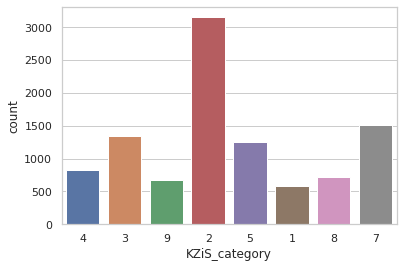

In [ ]:
sns.countplot(x="KZiS_category",data=data)

In [ ]:
# getting basic info about the dataset
# na początku było 10082 rekordów i 5 kolumn)
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10062 entries, 0 to 10081
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   class                  10062 non-null  object
 1   desc_tokenized&joined  10062 non-null  object
 2   KZiS_category          10062 non-null  object
dtypes: object(3)
memory usage: 572.5+ KB


(10062, 3)

In [ ]:
data.drop('class', axis=1, inplace=True)

In [ ]:
data.rename(columns={'desc_tokenized&joined':'text', 'KZiS_category':'cat'}, inplace=True)
data.head(5)

,text,cat
0,pracownik obsługi biurowej staż z urzędu pracy...,4
1,handlowiec pracownik biurowy oferta pracy prac...,3
2,pomoc biurowa oferta pracy umowa zlecenie umow...,4
3,pomoc biurowa oferta pracy umowa zlecenie umow...,4
4,sprzątaczka biurowa inwemer system spółka z og...,9


##Logistic Regression model for our new dataset

In [ ]:
# X = data.text
# y = df.cat
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
X_train=df['text']
y_train=df['cat']
X_test=data['text']
y_test=data['cat']

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(703887,)
(703887,)
(10062,)
(10062,)


In [ ]:
logreg1 = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg1.fit(X_train, y_train)

%time

y_pred_logreg = logreg1.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred_logreg, y_test))
print(classification_report(y_test, y_pred_logreg))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs
accuracy 0.7405088451600079
              precision    recall  f1-score   support

           1       0.80      0.59      0.68       582
           2       0.74      0.90      0.81      3152
           3       0.65      0.50      0.57      1346
           4       0.68      0.65      0.67       827
           5       0.79      0.74      0.76      1251
           7       0.81      0.74      0.78      1504
           8       0.82      0.73      0.77       719
           9       0.64      0.74      0.69       681

    accuracy                           0.74     10062
   macro avg       0.74      0.70      0.71     10062
weighted avg       0.74      0.74      0.74     10062



##SVM model fro new dataset

In [ ]:
sgd1 = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd1.fit(X_train, y_train)

%time

y_pred_svm = sgd1.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred_svm, y_test))
print(classification_report(y_test, y_pred_svm))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.3 µs
accuracy 0.693500298151461
              precision    recall  f1-score   support

           1       0.77      0.42      0.55       582
           2       0.72      0.83      0.77      3152
           3       0.81      0.31      0.45      1346
           4       0.69      0.65      0.67       827
           5       0.69      0.80      0.74      1251
           7       0.64      0.73      0.68      1504
           8       0.70      0.78      0.74       719
           9       0.61      0.73      0.66       681

    accuracy                           0.69     10062
   macro avg       0.70      0.66      0.66     10062
weighted avg       0.71      0.69      0.68     10062



##NB for our new dataset

In [ ]:
nb1 = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb1.fit(X_train, y_train)

%time
from sklearn.metrics import classification_report
y_pred = nb1.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.68 µs
accuracy 0.6158815344861857
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       582
           2       0.56      0.95      0.71      3152
           3       0.55      0.30      0.39      1346
           4       0.68      0.50      0.58       827
           5       0.71      0.56      0.63      1251
           7       0.78      0.61      0.68      1504
           8       0.88      0.48      0.62       719
           9       0.52      0.63      0.57       681

    accuracy                           0.62     10062
   macro avg       0.58      0.50      0.52     10062
weighted avg       0.61      0.62      0.58     10062



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
